<a href="https://colab.research.google.com/github/CorentinMAG/CV/blob/main/ML4CV_2_linear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let's start with the usual imports.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import math
from timeit import default_timer as timer

plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['font.size'] = 16

Let's grab CIFAR-10, split it into train, valid and test set, and flatten the images to create feature matrices. 

This is the same code we used for k-nn classification.

In [ ]:
num_classes = 10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

train_ds = torchvision.datasets.CIFAR10(root="/data/", train=True, transform=transforms.ToTensor(), download=True)
test_ds = torchvision.datasets.CIFAR10(root="/data/", train=False, transform=transforms.ToTensor())

train_ds

Extracting /data/cifar-10-python.tar.gz to /data/


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /data/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
splitted_datasets = torch.utils.data.random_split(train_ds, [45000, 5000])
actual_train_subds = splitted_datasets[0]
valid_subds = splitted_datasets[1]

In [ ]:
def dataset_to_matrix(dset, limit=None):
  x = torch.tensor(dset.data, dtype=torch.float32).permute(0, 3, 1, 2).div_(255)
  x = x.reshape((x.shape[0], -1))
  y = torch.tensor(dset.targets, dtype=torch.int64)
  if limit is not None:
    if limit <= 0 or limit > x.shape[0]:
      raise ValueError(f'Invalid value limit={limit}; must be in the range [0, {x.shape[0]}]')
    x = x[:limit].clone()
    y = y[:limit].clone()
  return x, y

def subset_to_matrix(dset, limit=None):
  x = torch.tensor(dset.dataset.data[dset.indices,], dtype=torch.float32).permute(0, 3, 1, 2).div_(255)
  x = x.reshape((x.shape[0], -1))
  y = torch.tensor(np.array(dset.dataset.targets)[dset.indices], dtype=torch.int64)
  if limit is not None:
    if limit <= 0 or limit > x.shape[0]:
      raise ValueError(f'Invalid value limit={limit}; must be in the range [0, {x.shape[0]}]')
    x = x[:limit].clone()
    y = y[:limit].clone()
  return x, y
  
small_train_features, small_train_labels = subset_to_matrix(actual_train_subds, 500)
small_valid_features, small_valid_labels = subset_to_matrix(valid_subds, 100)
small_test_features, small_test_labels = dataset_to_matrix(test_ds, 100)
small_train_features.shape

torch.Size([500, 3072])

Let's create two random matrices of the appropriate sizes to store the weights and biases. We will initialize `W` with values sampled from the standard Gaussian (i.e. $\mu$=0 and $\sigma$=1), while we will start from 0 for the biases.

In [ ]:
def init():
  W = torch.randn((small_train_features.shape[1], len(classes)))
  b = torch.zeros((len(classes)))
  return W, b

W, b = init()
print(W.shape, b.shape)
W, b

torch.Size([3072, 10]) torch.Size([10])


(tensor([[ 1.4103,  0.6194, -0.4598,  ..., -0.1235,  1.3348,  0.8593],
         [ 0.6198,  0.1191,  0.1098,  ..., -0.3327, -1.3806,  0.1351],
         [-0.3799, -0.7817, -0.5622,  ..., -1.0436,  0.9549,  0.0224],
         ...,
         [-1.8045,  0.2774, -1.8392,  ...,  0.3748, -0.2027, -0.0292],
         [ 0.2892, -1.6790,  0.9538,  ...,  0.8514,  0.2507, -0.1369],
         [ 0.6199,  0.7372, -0.7603,  ...,  0.2251, -0.3153, -1.0550]]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

We can then define our linear classifier. To multiply matrices stored into PyTorch tensors we use the `torch.matmul` function. Note that, since we have as input a matrix with num_samples $\times$ num_features, we actually compute x $\times$ W, not W $\times$ x as assumed in the slides.

We immediately verify that the shape of its output make sense and that we can apply it not only to one image, but to a set of examples stored into our feature matrix. If the size of the input is num_sample $\times$ D, the output will have size num_samples $\times$ classes.

In [ ]:
def linear_classifier(x, W, b):
  return torch.matmul(x, W) + b

scores = linear_classifier(small_train_features[0:2,:], W, b)
print(scores.shape, scores)

torch.Size([2, 10]) tensor([[-29.8983, -21.1509,  32.6900,  -4.8978, -45.7986,   3.1155, -78.2315,
           1.0151,  23.7017,  80.2408],
        [-43.8543, -14.1994,  44.5354,  10.5250, -44.2320, -34.9185, -37.6748,
          20.7777,  41.2456,  71.5485]])


Instead of writing the cross entropy loss from scratch, let's use Pytorch one. It's an opportunity to get to know the framework. In particular, useful functions related to (neural network) training, are available in the `torch.nn.functional` package, which we imported as `F` in the first cell.

Let's check the function documentation by using the `help` function.

In [ ]:
help(F.cross_entropy)

Help on function cross_entropy in module torch.nn.functional:

cross_entropy(input, target, weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='mean')
    This criterion combines `log_softmax` and `nll_loss` in a single
    function.
    
    See :class:`~torch.nn.CrossEntropyLoss` for details.
    
    Args:
        input (Tensor) : :math:`(N, C)` where `C = number of classes` or :math:`(N, C, H, W)`
            in case of 2D Loss, or :math:`(N, C, d_1, d_2, ..., d_K)` where :math:`K \geq 1`
            in the case of K-dimensional loss.
        target (Tensor) : :math:`(N)` where each value is :math:`0 \leq \text{targets}[i] \leq C-1`,
            or :math:`(N, d_1, d_2, ..., d_K)` where :math:`K \geq 1` for
            K-dimensional loss.
        weight (Tensor, optional): a manual rescaling weight given to each
            class. If given, has to be a Tensor of size `C`
        size_average (bool, optional): Deprecated (see :attr:`reduction`). By default,
   

The important part is the shape of its input arguments. Scores (aka `input`) must be **num_samples $ \times $ classes**, while targets must be a 1D vector of length **num_samples**. Note this is not the one-hot encoding of the labels, but the labels themselves.

Let's check what is the shape of the labels and of the scores we have.

In [ ]:
small_train_labels.shape

torch.Size([500])

In [ ]:
scores = linear_classifier(small_train_features, W, b)
scores.shape

torch.Size([500, 10])

Looks good! They match what cross_entropy expects. We can run it.

In [ ]:
loss = F.cross_entropy(scores, small_train_labels)
loss

tensor(51.7041)

Good! It runs without errors. Are we happy? No. Why? That's a suspiciously high value for the loss of a randomly initialized classifier...

With random weights, we would expect an almost uniform probability over the classes, which results in a value for the loss $\simeq -\log(\frac{1}{C}) = \log(C)$, which for CIFAR10 should be $\simeq 2.3$. What's going on?

Let's check if PyTorch is computing what we expect. Let's look at the first incorrectly classified image. What's the value of the scores?

In [ ]:
def first_misclassified_sample_index(scores, labels):
  return torch.nonzero(torch.argmax(scores, dim=1) != labels, as_tuple=False)[0].item()
first_misclassified_index = first_misclassified_sample_index(scores, small_train_labels)
first_misclassified_index

0

In [ ]:
first_misclassified_scores = scores[first_misclassified_index,:]
first_misclassified_scores

tensor([-29.8984, -21.1509,  32.6900,  -4.8978, -45.7986,   3.1155, -78.2315,
          1.0152,  23.7017,  80.2408])

The log likelihood uses only the score of the true label, let's grab it. Notice we can use the method `item()` to retrieve the value inside a tensor which has 0 dimensions (i.e. a scalar).

In [ ]:
first_misclassified_scores_yi = first_misclassified_scores[small_train_labels[first_misclassified_index]].item()
first_misclassified_scores_yi

-29.898353576660156

If you check in the slides, you can see that we derive an expression for the cross-entropy loss that involves this score and the `logsumexp` of all the scores. Hence we can compute the value we expect for the loss as follows.

In [ ]:
lse = torch.logsumexp(first_misclassified_scores, 0).item()
-first_misclassified_scores_yi+lse

110.13919067382812

Let's see what PyTorch returns if we apply the loss only to the first wrongly predicted item. Since the function is designed to work on batch of data, we have do adjust shapes to make it work on just one example, that's why we reshape scores and labels after having selected the row we care about.

In [ ]:
F.cross_entropy(first_misclassified_scores.reshape(1,-1), small_train_labels[first_misclassified_index].reshape(1)).item()

110.13919067382812

Looks PyTorch is doing what we expect (and we also validated we are calling the function correctly).

Let's see what is the accuracy of our randomly initialized model.

In [ ]:
def accuracy(scores, y):
  y_hat = torch.argmax(scores, 1)
  correct = (y_hat==y).sum()
  return correct.true_divide(y.shape[0])

accuracy(scores, small_train_labels)

tensor(0.1040)

At least that's reasonable! We expect about 10% accuracy for a randomly initialized model. Well, then, let's ignore the loss problem for know (you shouldn't ignore it when working on your projects!) and go on.

We have the model and we have initialized its parameters. To train it with gradient descent, we need to compute the gradient of the loss with respect to the parameters. To do it, we will use automatic differentiation, which you can invoke on a tensor, usually on the one storing the loss value, by calling `backward()`.

In [ ]:
# Uncomment to see the error
# loss.backward()

Ops... What's the cause of this error?

To have Pytorch do all the work for us, we have to tell it which tensors are the parameters! More precisely, we need to tell PyTorch which gradients it should compute, by calling the function `requires_grad_` on the tensors storing the parameters. PyTorch convention: if a function ends with _ (underscore) it modifies the tensor it is called on **in-place**, i.e. it does not create a copy and does not return a new tensor.

In [ ]:
W.requires_grad_(True)
b.requires_grad_(True)
b

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

You can see that by printing `b`, we now get a tensor with the field `requires_grad=True`.

Let's see if now we can use `backward`. Since we modified `W` and `b`, we must re-run also the forward pass, i.e. call `linear_classifier` on the training data.

In [ ]:

scores = linear_classifier(small_train_features, W, b)
loss = F.cross_entropy(scores, small_train_labels)
loss.backward()

It works! But where are the gradients? 

They are stored in the attribute `grad` of each tensor for which we required them.

In [ ]:
W.grad.shape, b.grad.shape, b.grad

(torch.Size([3072, 10]),
 torch.Size([10]),
 tensor([-0.0800, -0.0800,  0.0083, -0.1078, -0.1060, -0.1218, -0.0760, -0.0890,
         -0.1045,  0.7567]))

Great! Now we can put everything together and write the main loop that performs gradient descent. In your training loop it is very important to **remember to zero the gradients** after you have used them, otherwise subsequent calls to `backward` will keep accumulating them (and your model may even train correctly for a while...).

In [ ]:
# let's first esare the gradient we just computed 
with torch.no_grad():
  W.grad.zero_()
  b.grad.zero_()

epochs = 100
lr = 1e-3

for e in range(epochs):
  #forward pass
  scores = linear_classifier(small_train_features, W, b)
  loss = F.cross_entropy(scores, small_train_labels)
  #backward pass
  loss.backward()
  # compute training metrics
  acc = accuracy(scores, small_train_labels).item()
  

  with torch.no_grad():
    # compute validation loss and metrics
    valid_scores = linear_classifier(small_valid_features, W, b)
    valid_loss = F.cross_entropy(valid_scores, small_valid_labels).item()
    valid_acc = accuracy(valid_scores, small_valid_labels).item()
  
    #update parameters
    W -= lr * W.grad
    b -= lr * b.grad

    #zero the gradients, VERY IMPORTANT!
    W.grad.zero_()
    b.grad.zero_()
  
  if e % 10 == 0:
    print(f"Epoch {e}: train loss {loss:.3f} - train acc {acc:.3f} - valid loss {valid_loss:.3f} - valid acc {valid_acc:.3f}")


Epoch 0: train loss 51.704 - train acc 0.104 - valid loss 51.934 - valid acc 0.120
Epoch 10: train loss 47.467 - train acc 0.104 - valid loss 47.528 - valid acc 0.110
Epoch 20: train loss 43.873 - train acc 0.102 - valid loss 43.744 - valid acc 0.090
Epoch 30: train loss 40.803 - train acc 0.104 - valid loss 40.551 - valid acc 0.110
Epoch 40: train loss 38.212 - train acc 0.118 - valid loss 37.919 - valid acc 0.110
Epoch 50: train loss 35.992 - train acc 0.120 - valid loss 35.629 - valid acc 0.120
Epoch 60: train loss 34.064 - train acc 0.122 - valid loss 33.649 - valid acc 0.110
Epoch 70: train loss 32.408 - train acc 0.136 - valid loss 31.951 - valid acc 0.120
Epoch 80: train loss 30.947 - train acc 0.126 - valid loss 30.460 - valid acc 0.120
Epoch 90: train loss 29.612 - train acc 0.120 - valid loss 29.107 - valid acc 0.140


Training loss is still very high and the accuracy oscillates around the random guessing value of 0.1. 

Let's check if the first misclassified example has improved.

In [ ]:
scores = linear_classifier(small_train_features, W, b)
print(f"Correct class {small_train_labels[first_misclassified_index].item()}, predicted class {scores[first_misclassified_index,:].argmax()}")
print(f"Correct class score {scores[first_misclassified_index, small_train_labels[first_misclassified_index]].item():.3f}, predicted class score {scores[first_misclassified_index,:].max():.3f}")
scores[first_misclassified_index,:]

Correct class 0, predicted class 9
Correct class score -21.620, predicted class score 39.093


tensor([-21.6198, -14.2640,  16.7861,   4.0014, -37.2333,  12.0552, -71.4922,
          9.0663,  24.3931,  39.0931], grad_fn=<SliceBackward>)

It looks like the score associated to the real class is still very low compared to the (wrongly) predicted class. It will take gradient descent a long sequence of small steps to switch ranks of these scores. Do we really need the scores to be so large?How large are they on average?

In [ ]:
scores.abs().mean(dim=1).mean()

tensor(17.4143, grad_fn=<MeanBackward0>)

Why are they so large? The input pixels are always in $[0,1]$, so the magnitude of the scores depends only on the weights and baises.

We sampled weights from a standard Gaussian, hence with zero mean. The magnitude of the weights is therefore proportional to the variance, which is 1. We will study this in more detail later in the course, but it makes intuitive sense that one way to have small scores is to start from smaller weights at initialization, hence to sample with a Gaussian with zero mean but smaller variance/standard deviation.

Let's redefine the function `init` to accept a parameter `sigma`. We also set `requires_grad_=True` before returning the tensors.

In [ ]:
def init(sigma = 0.001):
  W = torch.normal(0, sigma, (small_train_features.shape[1], len(classes)))
  b = torch.zeros((len(classes)))
  return W.requires_grad_(), b.requires_grad_()

W, b = init()
print(f"Weight variance: {W.var().sqrt().item()}")
W, b

Weight variance: 0.0009994901483878493


(tensor([[ 1.4503e-03,  7.6307e-04,  2.0230e-03,  ...,  5.4341e-04,
          -2.1671e-03,  9.1931e-04],
         [-7.6967e-04, -7.5569e-05, -1.4158e-03,  ..., -6.2379e-04,
          -6.6368e-04, -1.0241e-03],
         [ 1.1066e-04, -1.0137e-03,  5.4236e-04,  ...,  4.0703e-04,
          -4.3146e-04, -1.5288e-03],
         ...,
         [-7.4314e-04, -1.0468e-03, -5.4072e-04,  ..., -1.0468e-03,
           1.6905e-04, -1.9700e-04],
         [ 3.1364e-04,  6.9239e-04,  9.5061e-05,  ..., -9.0402e-04,
           4.5499e-04,  1.2117e-03],
         [ 1.2883e-04,  7.0464e-04, -1.1883e-03,  ..., -7.3394e-04,
          -3.0402e-04, -1.1770e-03]], requires_grad=True),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True))

The exact value of $\sigma$ is actually not really important for a simple linear classifier, you can try other sigmas smaller than 1. This value will be instead critical for deep neural networks.  Let's check how large are the scores now.

In [ ]:
with torch.no_grad():
  scores = linear_classifier(small_train_features, W, b)
  print(scores.abs().mean(dim=1).mean())

tensor(0.0265)


Let's see if this initialization improves the training. We also create a function putting together initialiation and training, to be ready to use it in a model selection loop.

In [ ]:
def train_linear_classifier(train_features, train_labels, epochs, lr, valid_features=None, valid_labels=None, verbose=False):
  W,b = init()
  best_valid_acc = 0
  best_params = [W,b]
  best_epoch = -1

  for e in range(epochs):
    scores = linear_classifier(train_features, W, b)
    loss = F.cross_entropy(scores, train_labels)
    acc = accuracy(scores, train_labels).item()
    loss.backward()

    with torch.no_grad():
      
      W -= lr * W.grad
      b -= lr * b.grad

      W.grad.zero_()
      b.grad.zero_()

      if valid_features is not None:
        valid_scores = linear_classifier(valid_features, W, b)
        valid_loss = F.cross_entropy(valid_scores, valid_labels).item()
        valid_acc = accuracy(valid_scores, valid_labels).item()
      
      if valid_features is None or valid_acc > best_valid_acc:
        best_valid_acc = valid_acc if valid_features is not None else 0
        best_params = [W, b] 
        best_epoch = e

      
    if verbose and e % 50 == 0:
      print(f"Epoch {e}: train loss {loss:.3f} - train acc {acc:.3f}" + ("" if valid_features is None else f" - valid loss {valid_loss:.3f} - valid acc {valid_acc:.3f}"))
  
  if verbose and valid_features is not None:
    print(f"Best epoch {best_epoch:.3f}, best acc {best_valid_acc:.3f}")

  return best_valid_acc, best_params, best_epoch

epochs = 2000
lr = 1e-3
start=timer()
_, final_params, _ = train_linear_classifier(small_train_features, small_train_labels, epochs=epochs, lr=lr, valid_features=small_valid_features, valid_labels=small_valid_labels,  verbose=True)
end=timer()
print(f"Elapsed time (s): {end-start:.3f}")

Epoch 0: train loss 2.304 - train acc 0.110 - valid loss 2.301 - valid acc 0.090
Epoch 50: train loss 2.228 - train acc 0.170 - valid loss 2.250 - valid acc 0.120
Epoch 100: train loss 2.179 - train acc 0.252 - valid loss 2.214 - valid acc 0.160
Epoch 150: train loss 2.138 - train acc 0.288 - valid loss 2.185 - valid acc 0.190
Epoch 200: train loss 2.102 - train acc 0.316 - valid loss 2.160 - valid acc 0.210
Epoch 250: train loss 2.071 - train acc 0.332 - valid loss 2.139 - valid acc 0.210
Epoch 300: train loss 2.044 - train acc 0.342 - valid loss 2.120 - valid acc 0.220
Epoch 350: train loss 2.019 - train acc 0.344 - valid loss 2.103 - valid acc 0.240
Epoch 400: train loss 1.997 - train acc 0.360 - valid loss 2.089 - valid acc 0.230
Epoch 450: train loss 1.976 - train acc 0.364 - valid loss 2.076 - valid acc 0.220
Epoch 500: train loss 1.958 - train acc 0.380 - valid loss 2.064 - valid acc 0.230
Epoch 550: train loss 1.940 - train acc 0.386 - valid loss 2.053 - valid acc 0.230
Epoch 6

It does! Now we are getting reasonable loss values and validation accuracies comparable to what we were getting with the k-nn classifier (but investing way less time to achieve them). 

Let's check if the magnitude of the scores has remained small enough.

In [ ]:
with torch.no_grad():
  scores = linear_classifier(small_train_features, final_params[0], final_params[1])
  print(scores.abs().mean(dim=1).mean())

tensor(0.6529)


Looks so. To check the approximate constancy of statistics of the output and/or the parameters will be an important debugging/studying technique also when we will move to models more complex than linear classifiers.

Let's create a function to run hyper-parameters tuning, then. The most important hyper-parameter is of course the learning rate. We will also keep track of the epoch at which we achieve the best validation accuracy, as training time can be thought of as an hyper-parameter influencing "model complexity": the more we train, the more we fit the training data.

Since $0.001$ worked reasonably well above, I'll test it together with a few larger learning rates.  

In [ ]:
def hyperparameter_tuning(train_features, train_labels, valid_features, valid_labels, lrs= [1e-6 * 10**i for i in range(5)], epochs=1000):
  
  best_valid_acc = 0
  best_params = []
  best_hyper_params = []

  for lr in lrs:
    run_valid_acc, params, epoch = train_linear_classifier(train_features, train_labels, epochs=epochs, lr=lr, valid_features=valid_features, valid_labels=valid_labels, verbose=False)

    if run_valid_acc > best_valid_acc:
      best_valid_acc = run_valid_acc
      best_params = params
      best_hyper_params = [lr, epoch]
      print(f"Improved result: acc {best_valid_acc:.3f}, lr {lr}, epoch {epoch} ")
  return best_hyper_params, best_params

lrs = [1e-3, 3.3e-3, 1e-2, 3.3e-2]
start=timer()
best_hyper_params, best_params = hyperparameter_tuning(small_train_features, small_train_labels, small_valid_features, small_valid_labels, lrs)
end=timer()
print(f"Elapsed time (s): {end-start:.3f}")
print(f"best lr {best_hyper_params[0]}, best epoch {best_hyper_params[1]}")

Improved result: acc 0.240, lr 0.001, epoch 443 
Improved result: acc 0.310, lr 0.0033, epoch 758 
Improved result: acc 0.320, lr 0.033, epoch 260 
Elapsed time (s): 15.166
best lr 0.033, best epoch 260


Look likes we are getting reasonable values. We can now move to the full dataset.

In [ ]:
train_features, train_labels = subset_to_matrix(actual_train_subds)
valid_features, valid_labels = subset_to_matrix(valid_subds)
test_features, test_labels = dataset_to_matrix(test_ds)

And run model selection on it.

In [ ]:
lrs = [1e-3, 3.3e-3, 1e-2]
start=timer()
best_hyper_params, best_params = hyperparameter_tuning(train_features, train_labels, valid_features, valid_labels, lrs)
end=timer()
print(f"Elapsed time (s): {end-start:.3f}")

Improved result: acc 0.327, lr 0.001, epoch 993 
Improved result: acc 0.367, lr 0.0033, epoch 930 
Improved result: acc 0.389, lr 0.01, epoch 953 
Elapsed time (s): 950.852


Now we can run training on the full training set, putting back into it the validation set. How long should we train? We do not have anymore a validation set to monitor to know when to stop. Here we will train for as many epochs as we trained to achieve the best validation accuracy during model selections. Other strategies are possible and we will discuss them in upcoming lessons.

In [ ]:
all_train_features = torch.cat((train_features, valid_features))
all_train_labels = torch.cat((train_labels, valid_labels))
best_lr, best_epoch = best_hyper_params[0], best_hyper_params[1]
run_valid_acc, best_params, _ = train_linear_classifier(all_train_features, all_train_labels, epochs=best_epoch, lr=best_lr, verbose=False)

Finally, we can test the trained model on the full test set.

In [ ]:
start = timer()
test_scores = linear_classifier(test_features, best_params[0], best_params[1])
end = timer()
test_acc = accuracy(test_scores, test_labels)
print(f"Accuracy on full test set {test_acc:.3f}, elapsed time (s): {end-start:.3f}")

Accuracy on full test set 0.378, elapsed time (s): 0.028


We obtain similar test accuracy than k-nn, in a fraction of a second. Training is still slow for a small dataset like CIFAR-10. We will address this shortcoming in the next lesson.

What do the best parameters look like? We can collect statistics to describe them, but in the spirit of our "always look at the data" mantra, we can try to get a visualization of them. 

To compute the score $s_j$, we multiply the input image for the $j$-th column of $W$, which is of size $3072 \times 1$. To visualize it as an image, we have to
 
1.   bring the values back in the range $[0,1]$ (recall that weights can assume any value during training). One simple way to do so is to subtract the minimum and the divide by the maximum of the resulting tensor.

2.   "Unflatten" the column, bringing it back to the shape of the input images, i.e. $3 \times 32 \times 32$. 
 

In the following cell, we perform these operations for all the rows at once. 

In [ ]:
best_templates = best_params[0].detach().clone()
best_templates -= best_templates.min(0, keepdim=True)[0]
best_templates /= best_templates.max(0, keepdim=True)[0]
best_templates = best_templates.reshape(3,32,32,10)
best_templates.shape

torch.Size([3, 32, 32, 10])

We can now define our usual `show` function and visualize the "template" for the class *horse*. Depending on your training hyper-parameters you can obtain smooth or noisy results.

In [ ]:
%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.axis('off')

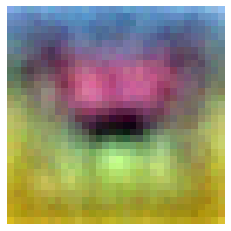

In [ ]:
show(best_templates[:, :, :, 7])

And then visualize all of them.

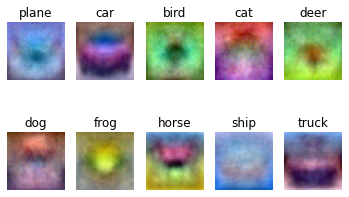

In [ ]:
def show_templates(best_templates):
  n_classes = 10
  for i in range(n_classes):
    plt.subplot(2, n_classes/2, i+1)
    show(best_templates[:, :, :, i])
    plt.title(classes[i])
  plt.subplots_adjust(hspace = 0.02) 
show_templates(best_templates)

# That's all, folks